# Algoritmos Evolutivos

Optimización de la función de rastrigin:

- 20 dimensiones
- 100 individuos
- Cien mil iteraciones
- 30 experimentos (corridas)

Se definió que cada dimensión se codifque en $17$ bits; por tanto la longitud de un individuo es $n_{dims}* 17$

La probabilidad de mutación es $0.5$.


Procedimiento: 

1. Se inicializa aleatoriamente con distribución uniforme la población.
2. Siguiente generación:
    1. Se eligen por ruleta dos individuos (padres).
    2. La combinación es el intercambio de bits desde un punto elegido al azar hasta el final. Este intercambio se itera $n_{dims}/3$ veces.
    3. Mutación:
        1. Para cada bit se toma un número aleatorio $\{0,...,1\}$
        2. Si el valor es menor a la probabilidad de mutación, se invierte el bit.
    4. Se generan tantos hijos como cantidad de población hay. 
    5. Se seleccionan por ranking entre los padres y los hijos los 100 mejores individuos para la siguiente generación.
3. Iterar

In [60]:
import numpy as np
import pandas as pd
import random
import math
import csv
import matplotlib.pyplot as plt
% matplotlib inline

from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool

In [55]:
bit_len=17 # 2**17 =131072
n_dims=20
cant_indiv=100
iteraciones=100000
iter_experimentos=30
mut_ratio=0.5
optim_type="minimize"
ref_rate=100

In [56]:
#Función de fitness
def rastrigin(X_array, A=10, m=0):
    n=len(X_array)
    y=A*n+(sum([(x_val**2)-(A*math.cos(2*math.pi*x_val))for x_val in X_array]))
    return y

def rastrigin_bit(indiv, A=10, m=0):
    X_array=[]
    #dim_bit=[bit_len*(dim+1) for dim in xrange(n_dims)]
    for i in xrange(n_dims):
        #coge un segmento de bitlen, lo asigna a decodificar y el resto lo reasigna al individuo.
        dec_seg=indiv[:bit_len]
        entero=((int(dec_seg,2)/float(2**bit_len))*10.24)-5.12
        indiv=indiv[bit_len:]
        X_array.append(entero)
    n=len(X_array)
    y=A*n+(sum([(x_val**2)-(A*math.cos(2*math.pi*x_val))for x_val in X_array]))
    return y

def gener_indiv():#bit_len, n_dims):
    # Generar un individuo de una cantidad de bits por las n dimensiones
    return ''.join([str(random.randint(0,1))for i in range(bit_len*n_dims)])

# Convertirlos al espacio de soluciones (decodificarlos)
def decode_indiv(indiv):#, bit_len, n_dims):
    coords=[]
    #dim_bit=[bit_len*(dim+1) for dim in xrange(n_dims)]
    for i in xrange(n_dims):
        #coge un segmento de bitlen, lo asigna a decodificar y el resto lo reasigna al individuo.
        dec_seg=indiv[:bit_len]
        entero=((int(dec_seg,2)/float(2**bit_len))*10.24)-5.12
        indiv=indiv[bit_len:]
        coords.append(entero)
    return coords

#Seleccion de ruleta
def selec_rulet(array_fits, n):
    #toma un array de fitness y devuelve los n padres
    elecs=[]
    tot_fits=sum([float(fit) for fit in array_fits[:,1]])
    probs=[(float(p_i)/tot_fits) for p_i in array_fits[:,1]]
    for i_num in xrange(n):
        r_num=random.random()
        cumsum=[sum(probs[:i+1]) for i in xrange(len(probs))]
        elec=None
        for i_sum in enumerate(cumsum):
            if r_num <= i_sum[1]:
                elec=array_fits[i_sum[0],0]
                break
        elecs.append(elec)
    return elecs


#Vector de fitness
def fit_vector(population):
    fit_vec=[[ind_pop,rastrigin(decode_indiv(ind_pop))] for ind_pop in population]
    fit_vec.sort(key=lambda x: x[1], reverse=not optim_type=="minimize")
    return np.array(fit_vec)


# crear un hijo (con mutación y selecion aleatoria de punto de cruce)
def mutation(indiv):
    return ''.join([(str((not bool(int(i)))*1) if random.random()<mut_ratio else str(bool(int(i))*1)) for i in indiv ])

def fili(fit_matrx):
    fit_matrx_2=np.copy(fit_matrx)
    if optim_type=="minimize":
        max_fit=max(fit_matrx[:,1].astype(float))
        fit_matrx_2[:,1]=[max_fit-float(fit_i) for fit_i in fit_matrx[:,1]]
    parents=selec_rulet(fit_matrx_2,2)
    for i in xrange(n_dims/3):
        punt_cruce=random.randrange(bit_len*n_dims)
        parents[0]=parents[0][:punt_cruce]+parents[1][punt_cruce:]
        parents[1]=parents[1][:punt_cruce]+parents[0][punt_cruce:]
    return ([mutation(parents[0]),mutation(parents[1])])


####___________________________________####
def plot_experim(evolution):
    plt.figure(figsize=(15,8))
    plt.plot(xrange(len(evolution[:,2])),evolution[:,3].astype(float))
    plt.plot(xrange(len(evolution[:,2])),evolution[:,1].astype(float),"g")
    plt.plot(xrange(len(evolution[:,2])),evolution[:,5].astype(float),"r--")
    plt.plot(xrange(len(evolution[:,2])),evolution[:,6].astype(float),"k", alpha=0.4)
    plt.fill_between(xrange(len(evolution[:,3])),evolution[:,6].astype(float)+evolution[:,4].astype(float)*0.5,
                     evolution[:,6].astype(float)-evolution[:,4].astype(float)*0.5,alpha=.3, color="k")
    plt.show(block=False)
####___________________________________####
def next_gen(popul_parents):
    '''
    Toma una población y devuelve a la siguiente generacón de hijos.
    Los padres se seleccionn por ruleta.
    los hijos y los padres se ordenan y se hace ranking dejando los mejores n de la población
    '''
    fitness_population=fit_vector(popul_parents)
    offsp=[]
    for n_ind in range(cant_indiv/2):# Generar nuevos hijos
        offsp.extend(fili(fitness_population))
    generations_AB=popul_parents+offsp# Generar nuevos hijos y agruparlos con los padres
    fitness_AB=fit_vector(generations_AB) # evaluar los fitness de todos
    pars_1=list(fitness_AB[:len(popul_parents),0]) # Seleccionar los n mejores de la pobl
    return pars_1


def get_best_fit(popul):
    ft_mtrx=fit_vector(popul)
#    return float(ft_mtrx[0,1])
    return float(ft_mtrx[0,1]), ft_mtrx[0,0]


####___________________________________Experimentos ___________________________________####

def experim_min():
    pars_1=[gener_indiv() for i in xrange(cant_indiv)]
    evolution=[]
    fitness_population=fit_vector(pars_1)
    evolution=[[len(set(pars_1)),
                fitness_population[0,1],
                fitness_population[0,0],
                round(np.median(fitness_population[:,1].astype(float)),2),
                round(np.std(fitness_population[:,1].astype(float)),2),
                round(float(fitness_population[-1,1]),2),
                round(np.mean(fitness_population[:,1].astype(float)),2)
               ]]#propiedades de las poblaciones a lo largo de las generaciones

# Evolucionar la pobación a lo largo de las iteraciones
    for i in xrange(iteraciones):
        offsp=[]
        for n_ind in range(cant_indiv):# Generar nuevos hijos
            offsp.extend(fili(fitness_population))
        generations_AB=pars_1+offsp# Generar nuevos hijos y agruparlos con los padres
        fitness_AB=fit_vector(generations_AB) # evaluar los fitness de todos
        pars_1=list(fitness_AB[:len(pars_1),0]) # Seleccionar los n mejores de la pobl
        fitness_population=fit_vector(pars_1) #Fitness de la nueva generación
        ### Nueva generacion
        inds_popul=len(set(pars_1))
        #fintess_offspring=fit_vector(pars_1)
        best_fitness=fitness_population[0,1]
        best_indiv=fitness_population[0,0]
        median_fit=round(np.median(fitness_population[:,1].astype(float)),2)
        desvest_fit=round(np.std(fitness_population[:,1].astype(float)),2)
        worst_fitness=round(float(fitness_population[-1,1]),2)
        avg_fit=round(np.mean(fitness_population[:,1].astype(float)),2)
        evolution.append([inds_popul,best_fitness,best_indiv,median_fit,desvest_fit,worst_fitness,avg_fit])
        
        if i % ref_rate==0:
            print(''.join(["iter: ",str(i),"/", str(iteraciones), "| Fitness: ",np.array(evolution)[-1,1]]))
            #plot_experim(np.array(evolution))
                    
    evolution=np.array(evolution)
    return evolution

In [ ]:
'''
Crear n_corridas de poblaciones
iterar sobre cada población calculando el fitness del mejor y dejándolo avanzar tantas iteraciones como pueda.
'''

#'''
prim_gen=[[gener_indiv() for ind in xrange(cant_indiv)] for iterac in xrange(iter_experimentos)]
best_nCorrds_mIters=[[get_best_fit(ith_popul)[0] for ith_popul in prim_gen]]#Registra el fitness del mejor de cada población por cada iteración
#fits_first_gen=np.array([round(float(get_best_fit(ith_popul)[1]),3) for ith_popul in prim_gen])
#np.savetxt("Results_1/corridas_primGen.csv",fits_first_gen)
best_nCorrds_mIters_bit=[str(get_best_fit([get_best_fit(ith_popul)[1] for ith_popul in prim_gen])[1])]#Registra el mejor individuo de cada población por cada iteración
for corrida in xrange(iteraciones):
    if __name__ == '__main__':
        pool = Pool()
        prim_gen=pool.map(next_gen,prim_gen)
        pool.close() 
        pool.join()

    fit_dat=np.array([get_best_fit(prox_gen) for prox_gen in prim_gen])
    best_popul=[float(fit[0]) for fit in fit_dat]# Regstra el mejor fitness de cada población
    best_popul_bit=[fit[1] for fit in fit_dat]#registra el mejor individuo de cada población
    best_nCorrds_mIters.append(best_popul)
    np.savetxt("Results_1/corridas.csv",np.array(best_nCorrds_mIters))
#    np.savetxt("Results_1/corridas_primGen_test.csv",np.array(best_nCorrds_mIters))
    best_corrida=list(get_best_fit(best_popul_bit))
#    print (best_corrida[1])
#    print (decode_indiv(best_corrida[1]))
    best_nCorrds_mIters_bit.append(str(best_corrida[1]))
    with open(''.join(["Results_1/corridas_best_bit",".csv"]), 'wb') as f:
        writer = csv.writer(f)
        [writer.writerow([best_bit])for best_bit in best_nCorrds_mIters_bit]

#    np.savetxt("Results_1/corridas_primGen_test_bit.csv",np.array([best_nCorrds_mIters_bit]))
    if corrida %ref_rate==0:
            print(''.join(["iter: ",str(corrida),"/", str(iteraciones), "| best corrida Fitness: ",str(best_corrida[0])]))
            #plot_experim(np.array(evolution))
            

iter: 0/100000| best corrida Fitness: 188.443806513
iter: 100/100000| best corrida Fitness: 142.941553756
iter: 200/100000| best corrida Fitness: 142.941553756
iter: 300/100000| best corrida Fitness: 142.941553756
iter: 400/100000| best corrida Fitness: 142.941553756
iter: 500/100000| best corrida Fitness: 142.941553756
iter: 600/100000| best corrida Fitness: 142.941553756
iter: 700/100000| best corrida Fitness: 142.941553756
iter: 800/100000| best corrida Fitness: 142.941553756
iter: 900/100000| best corrida Fitness: 142.941553756
iter: 1000/100000| best corrida Fitness: 142.941553756
iter: 1100/100000| best corrida Fitness: 142.941553756
iter: 1200/100000| best corrida Fitness: 142.941553756
iter: 1300/100000| best corrida Fitness: 142.941553756
iter: 1400/100000| best corrida Fitness: 142.941553756
iter: 1500/100000| best corrida Fitness: 142.941553756
iter: 1600/100000| best corrida Fitness: 142.941553756
iter: 1700/100000| best corrida Fitness: 142.941553756
iter: 1800/100000| bes

In [63]:
data=np.loadtxt("Results_1/corridas.csv")
best=[]
worst=[]
mean=[]
median=[]
std_median=[]

for iterac in data:
    best.append(min(iterac))
    worst.append(max(iterac))
    mean.append(np.mean(iterac))
    median.append(np.median(iterac))
    std_median.append(np.sqrt(sum([(fit-np.median(iterac))**2 for fit in iterac])/len(iterac)))

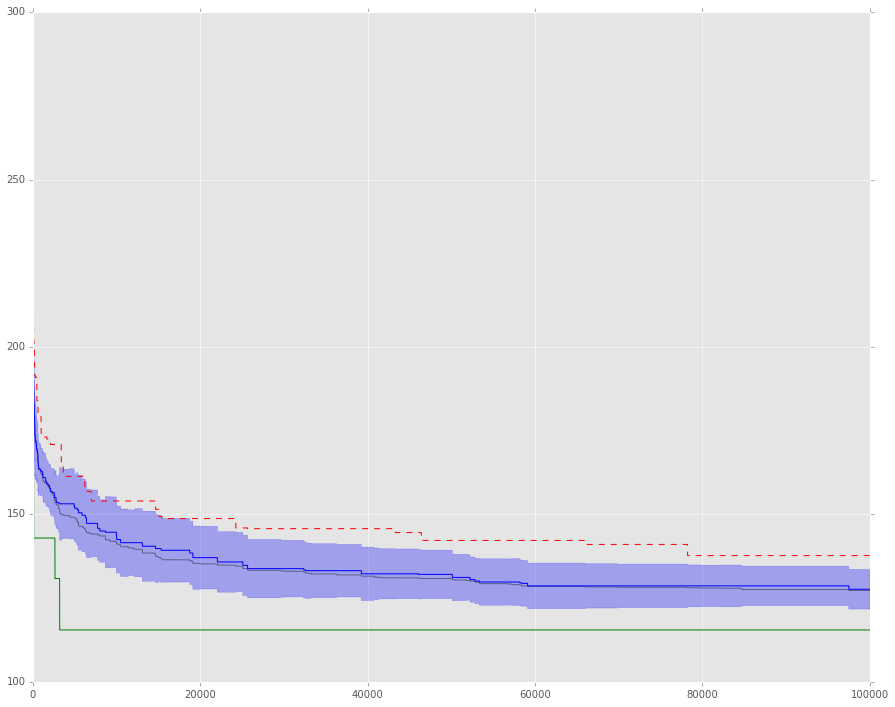

In [64]:
plt.figure(figsize=(15,12))
plt.plot(best, "g")
plt.plot(worst, "r--")
plt.plot(mean, "k", alpha=0.4)
plt.plot(median,"b")
plt.fill_between(xrange(len(np.array(median))),
                 np.array(median)+np.array(std_median),
                 np.array(median)-np.array(std_median),
                 alpha=0.3,
                 color="b")
plt.savefig("algor_evol.pdf")
plt.show()

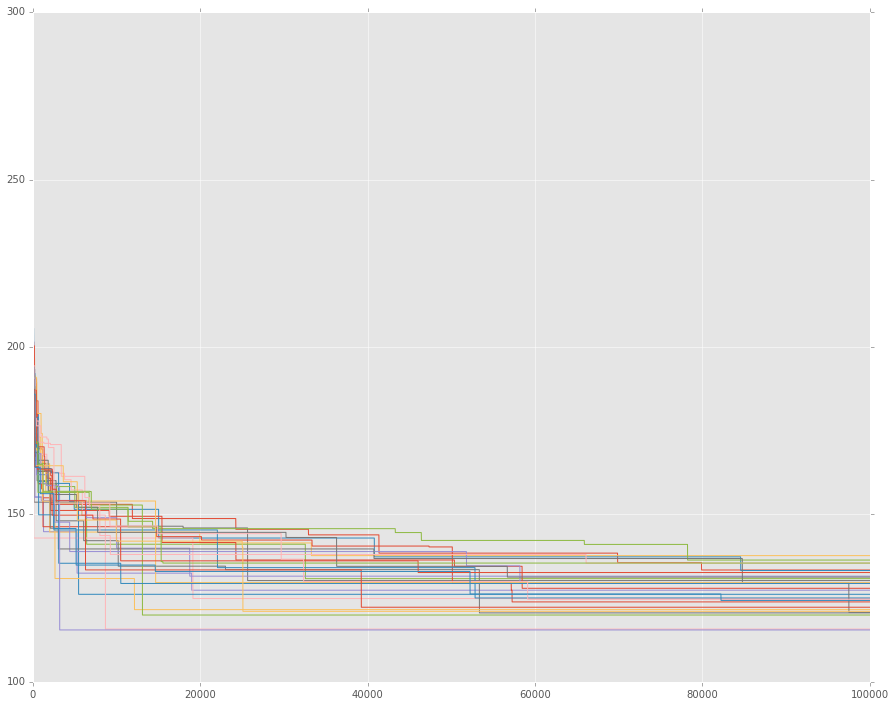

In [65]:
plt.figure(figsize=(15,12))
[plt.plot(dat) for dat in data.T]
plt.show()

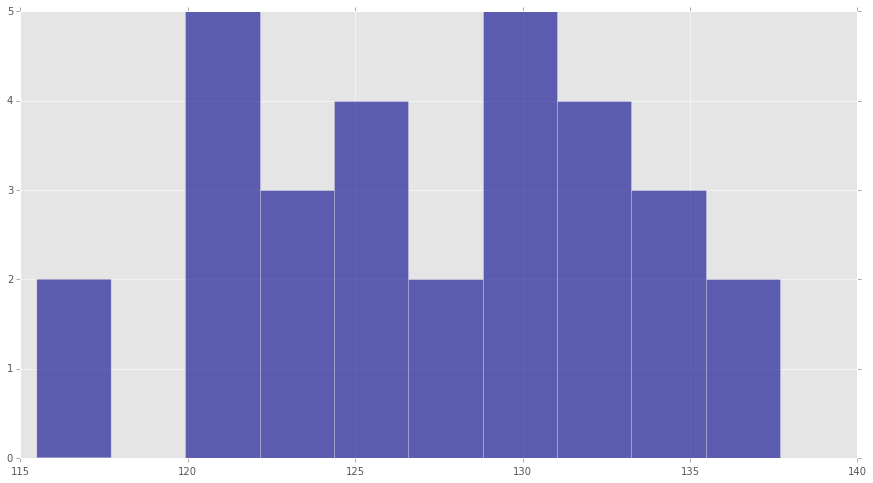

In [66]:
plt.figure(figsize=(15,8))
plt.hist(data[-1,:],color="darkblue", alpha=.6)
plt.show()

In [67]:
print data[-1]
min(data[-1])

[ 133.39517683  133.23768917  127.3537267   130.23433067  137.68858971
  130.80842932  124.86950283  123.86149825  126.13644463  131.55122366
  120.58447718  121.55853538  136.36330137  115.7486878   127.92975116
  125.04008278  129.41607643  120.74019533  129.63720159  119.94457908
  135.46306349  132.63627102  129.37472977  115.48785696  131.27464852
  121.05066976  135.46560183  124.63856355  122.27194806  124.30259876]


115.487856962

In [69]:
best_nCorrds_mIters_bit[-1]

'1001011110110010101010000011011111100011010001010110110100010000000001100111100001010011000101110010111001010001111011010011000101001000100110111100101110111111100111101010011100111101111100101111110100001010111101010110010000101111100001101100101101011010101000110100001101110010110001001101101010101101001011000101010101010010110101111000'

In [70]:
decode_indiv(best_nCorrds_mIters_bit[-1])

[0.9478906250000003,
 -1.9025781250000002,
 0.5233593750000001,
 -0.9400000000000004,
 -0.9792187500000002,
 -1.164140625,
 0.8192187500000001,
 0.9856249999999998,
 1.1117968750000005,
 -0.030468749999999822,
 1.1586718750000005,
 0.9562499999999998,
 1.8934375,
 0.23757812499999975,
 2.0335156249999997,
 -1.8547656250000002,
 -0.529296875,
 2.1340624999999998,
 1.9732812500000003,
 0.9093749999999998]